# 降维

## 基本概念

降维的意思是能够用一组个数为 $k$ 的向量 $\mathrm{z}_i$ 来代表个数为 $n$ 的向量 $\mathrm{x}_i$ 所包含的有用信息，其中 $k<n$。一方面数据有冗余，要么是一些没有用的信息，要么是一些重复表达的信息，降维之后存储参数的空间会减少很多，计算时间也会减少。另一方面，高维空间的数据很有可能出现分布稀疏的情况，每增加一维所需的样本个数呈指数级增长，这种在高维空间中样本稀疏的问题被称为维数灾难（`curse of dimensionality`)。降维可以缓解这种问题。

一般来说可以从两个角度来考虑做数据降维，一种是直接提取特征子集做特征抽取，一种是通过线性/非线性的方式将原来高维空间变换到一个新的空间。后面一种的角度一般有两种思路来实现，一种是基于从高维空间映射到低维空间的投影方法，其中代表算法就是`PCA`，而其他的`LDA`、`Autoencoder`也算是这种，主要目的就是学习或者算出一个矩阵变换 $P$，用这个矩阵与高维数据相乘得到低维数据。另一种是基于流形学习的方法，流形学习的目的是找到高维空间样本的低维描述。

### 降维的用处

- 随着数据维度不断降低，数据存储所需的空间也会随之减少。

- 低维数据有助于减少计算/训练用时。

- 一些算法在高维度数据上容易表现不佳，降维可提高算法可用性。

- 降维可以用删除冗余特征解决多重共线性问题。比如我们有两个变量：“一段时间内在跑步机上的耗时”和“卡路里消耗量”。这两个变量高度相关，在跑步机上花的时间越长，燃烧的卡路里自然就越多。因此，同时存储这两个数据意义不大，只需一个就够了。

- 降维有助于数据可视化。如前所述，如果数据维度很高，可视化会变得相当困难，而绘制二维三维数据的图表非常简单。

## 特征选择

### 单变量特征选择（Univariate feature selection）

单变量特征选择的原理是分别单独的计算每个变量的某个统计指标，根据该指标来判断哪些指标重要，剔除那些不重要的指标。在`sklearn`中，分别针对不同的统计检验方法和不同的排序选择标准提供了不同的工具，比如用于回归问题的`f_regression`、`mutual_info_regression`分数，用于分类问题的`f_classif`、`chi2`、`mutual_info_classf`分数；以及用于特征排序和选择的`SelectKBest`、`SelectPercentile`、`SelectFpr`等。

- `SelectKBest`删除除得分最高的特征之外的所有特征。
  
- `SelectPercentile`使用针对每个特征的常见单变量统计测试，删除除用户指定的得分最高的特征之外的所有特征。
  
- `GenericUnivariateSelect`允许使用可配置的策略执行单变量特征选择。这允许选择最佳的单变量选择策略与超参数搜索估计。

单变量特征选择方法就是将特征输入到评分函数，返回一个单变量的`f_score`(F检验的值)或`p-values`(P值，假设检验中的一个标准，`p-value`用来和显著性水平作比较)，注意`SelectKBest` 和 `SelectPercentile` 只有得分，没有`p-value`。对于方法的选择推荐如下：

- 回归的数据：`f_regression`，`mutual_info_regression`

- 分类的数据：`chi2`，`f_classif`，`mutual_info_classif`
  
如果使用稀疏数据(比如，使用稀疏矩阵表示的数据)，卡方检验(`chi2`)、互信息回归(`mutual_info_regression`)、互信息分类(`mutual_info_classif`)在处理数据时可保持其稀疏性，因此被推荐选择。但是要注意的是不要在分类问题上使用回归评分函数，否则将获得无用的结果。

### SelectKBest

SelectKBest方法就是从所有特征中挑选出最好的`K`个特征组成新的特征集。如何来定义最好呢？这要取决于评分函数，该方法默认会使用`f_classif`，这种方法适用于为分类模型评估特征，与之对应的是`f_regression`，它适用于回归模型的特征评估。

In [1]:
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("hw4-data.csv")

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


丢弃无效的数据。

In [4]:
df.drop(['id', 'Unnamed: 32'], axis=1,  inplace=True)

In [5]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
X = df.drop('diagnosis', axis=1)
y = LabelEncoder().fit_transform(df['diagnosis'])

数据要做归一化，否则很难收敛。

In [7]:
X = StandardScaler().fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

train score: 0.9868131868131869
test score: 0.9736842105263158


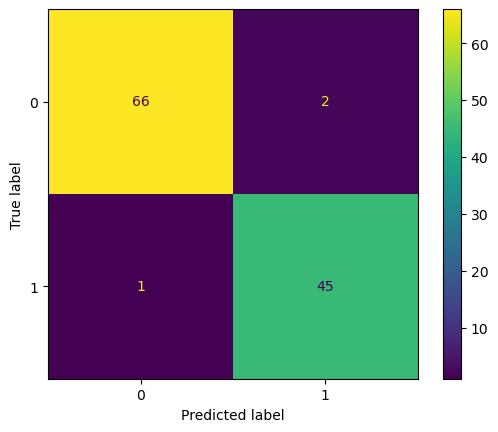

In [9]:
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
model = LogisticRegression()
model.fit(X_train, y_train)
print(f"train score: {model.score(X_train, y_train)}")
print(f"test score: {model.score(X_test, y_test)}")

#plot_confusion_matrix(model, X_test, y_test)
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [10]:
from sklearn.feature_selection import chi2, f_classif, f_regression

In [11]:
selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(X, y)
print(X_new.shape)
feature_scores = pd.DataFrame({'Features':df.columns[1:], 'Score': selector.scores_}).sort_values(by='Score', ascending=False)
display(feature_scores)

(569, 10)


,Features,Score
27,concave points_worst,964.385393
22,perimeter_worst,897.944219
7,concave points_mean,861.676020
20,radius_worst,860.781707
2,perimeter_mean,697.235272
23,area_worst,661.600206
0,radius_mean,646.981021
3,area_mean,573.060747
6,concavity_mean,533.793126
26,concavity_worst,436.691939


样本数不变，仍为569个，特征则被删减到了10个。接下来用这10个特征的数据来训练一个新的模型，测试模型的效果。

train score: 0.9624413145539906
test score: 0.958041958041958


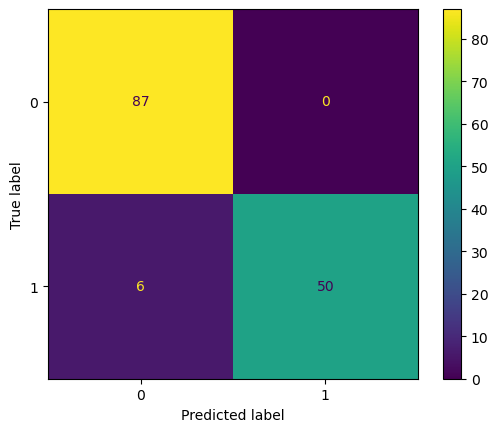

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=2022)
model = LogisticRegression()
model.fit(X_train, y_train)
print(f"train score: {model.score(X_train, y_train)}")
print(f"test score: {model.score(X_test, y_test)}")

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

### SelectPercentile


`SelectPercentile`的选取方式与`SelectKBest`略有不同，后者是选取在某种标准下最好的`K`个特征；而前者，则是在给定一个百分比的情况下，选择最好的特征。比如10个特征，前`20%`的特征就是最好的两个特征，以此类推。

其使用的评分标准与`SelectKBest`没有什么不同，按需传入所需的评分方法即可。需要注意的是，`percentile`接受的是一个0到100的整数。

(569, 18)


,Features,Score
27,concave points_worst,964.385393
22,perimeter_worst,897.944219
7,concave points_mean,861.676020
20,radius_worst,860.781707
2,perimeter_mean,697.235272
23,area_worst,661.600206
0,radius_mean,646.981021
3,area_mean,573.060747
6,concavity_mean,533.793126
26,concavity_worst,436.691939


train score: 0.9859154929577465
test score: 0.965034965034965


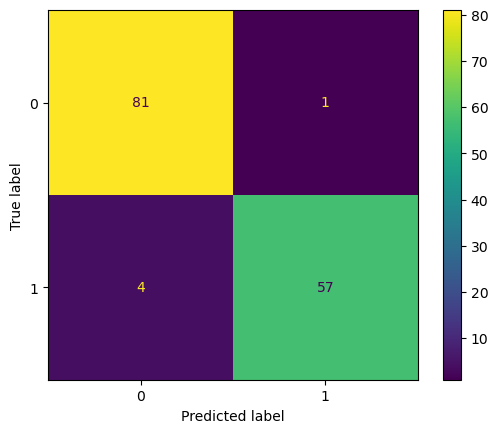

In [13]:
from sklearn.feature_selection import SelectPercentile
selector = SelectPercentile(f_classif, percentile=60)
X_new = selector.fit_transform(X, y)
print(X_new.shape)

feature_scores = pd.DataFrame({'Features':df.columns[1:], 'Score': selector.scores_}).sort_values(by='Score', ascending=False)
display(feature_scores)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=1001)
model = LogisticRegression()
model.fit(X_train, y_train)
print(f"train score: {model.score(X_train, y_train)}")
print(f"test score: {model.score(X_test, y_test)}")

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

### SelectFpr

前两种方法都很好理解，而`SelectFpr`方法则要求对假设检验有一定的认识。这种方法基于`FPR`测试，即`False Positive Rate`，其含义为假阳性率，是指被预测为正但实际为负的样本的比例，也就是假设检验中的一类错误发生的比例。

不想深究的同学可以直接简单粗暴地记住，这里就是按照`p-value`来筛选特征的，`p-value`越小越好，所有`p-value`低于我们设定的阈值 α 的特征都会被选择。由于这个例子中每个特征的`p-value`都很小，为了演示效果，我们把 $\alpha$ 设定到十万分之一：

(569, 25)


,Features,Score
27,concave points_worst,1.969100e-124
22,perimeter_worst,5.771397e-119
7,concave points_mean,7.101150e-116
20,radius_worst,8.482292e-116
2,perimeter_mean,8.436251e-101
23,area_worst,2.828848e-97
0,radius_mean,8.465941e-96
3,area_mean,4.734564e-88
6,concavity_mean,9.966556e-84
26,concavity_worst,2.464664e-72


train score: 0.9859154929577465
test score: 0.9790209790209791


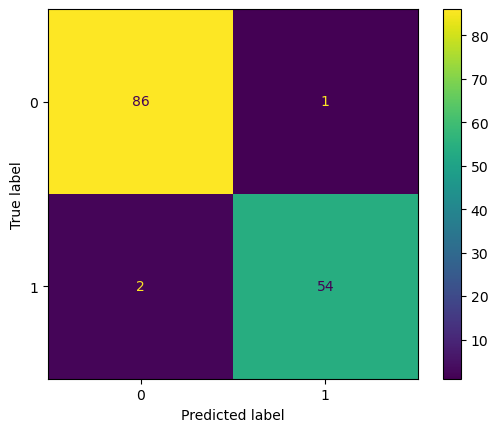

In [14]:
from sklearn.feature_selection import SelectFpr
selector = SelectFpr(f_classif, alpha=0.000001)
X_new = selector.fit_transform(X, y)
print(X_new.shape)

feature_scores = pd.DataFrame({'Features':df.columns[1:], 'Score': selector.pvalues_}).sort_values(by='Score', ascending=True)
display(feature_scores)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=2022)
model = LogisticRegression()
model.fit(X_train, y_train)
print(f"train score: {model.score(X_train, y_train)}")
print(f"test score: {model.score(X_test, y_test)}")

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

### SelectFdr
`SelectFdr`则是根据错误发现率（`FDR，False Discovery Rate`）来为特征排序。错误发现率与假阳性率非常相似，但是却有着本质的不同。假阳性率是在所有样本中一类错误发生的概率，而错误发现率则仅仅关注在我们拒绝原假设(预测为正)的样本中，有多大比例是犯了一类错误的（即在"发现"的样本里，有多少是错误的"发现"）。

`sklearn`中的`SelectFdr`方法使用`Benjamini-Hochberg`过程对`p-value`进行修正，并筛选出修正后的`p-value`在 $\alpha$ 水平以下的特征。这一过程的公式很简单，但是其原理较复杂。

(569, 25)


,Features,Score
27,concave points_worst,1.969100e-124
22,perimeter_worst,5.771397e-119
7,concave points_mean,7.101150e-116
20,radius_worst,8.482292e-116
2,perimeter_mean,8.436251e-101
23,area_worst,2.828848e-97
0,radius_mean,8.465941e-96
3,area_mean,4.734564e-88
6,concavity_mean,9.966556e-84
26,concavity_worst,2.464664e-72


train score: 0.9859154929577465
test score: 0.9790209790209791


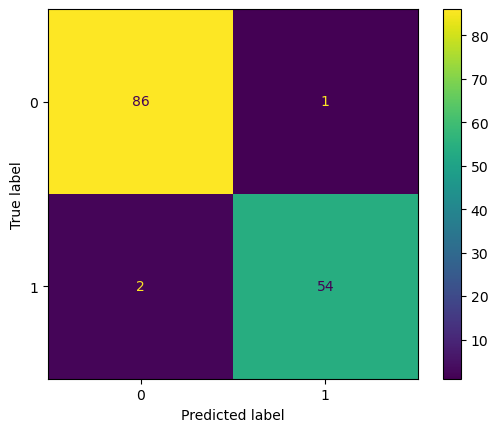

In [15]:
from sklearn.feature_selection import SelectFdr
selector = SelectFdr(f_classif, alpha=0.00001)
X_new = selector.fit_transform(X, y)
print(X_new.shape)

feature_scores = pd.DataFrame({'Features':df.columns[1:], 'Score': selector.pvalues_}).sort_values(by='Score', ascending=True)
display(feature_scores)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=2022)
model = LogisticRegression()
model.fit(X_train, y_train)
print(f"train score: {model.score(X_train, y_train)}")
print(f"test score: {model.score(X_test, y_test)}")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

### SelectFwe
在多重假设检验中，总体错误率(族系误差率，`Family-Wise Error Rate，FWER`)是另一个常用的错误控制指标，它与`FDR`的区别在于，`FWER`是指至少出现一次一类错误的概率，而`FDR`则是关注预测为正的样本中一类错误发生的比例。

(569, 25)


,Features,Score
27,concave points_worst,1.969100e-124
22,perimeter_worst,5.771397e-119
7,concave points_mean,7.101150e-116
20,radius_worst,8.482292e-116
2,perimeter_mean,8.436251e-101
23,area_worst,2.828848e-97
0,radius_mean,8.465941e-96
3,area_mean,4.734564e-88
6,concavity_mean,9.966556e-84
26,concavity_worst,2.464664e-72


train score: 0.9859154929577465
test score: 0.9790209790209791


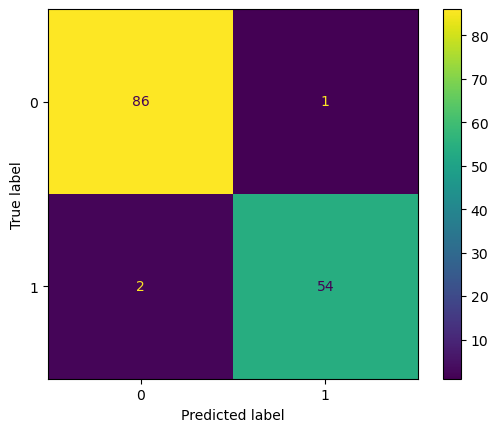

In [16]:
from sklearn.feature_selection import SelectFwe
selector = SelectFwe(f_classif, alpha=0.0000001)
X_new = selector.fit_transform(X, y)
print(X_new.shape)

feature_scores = pd.DataFrame({'Features':df.columns[1:], 'Score': selector.pvalues_}).sort_values(by='Score', ascending=True)
display(feature_scores)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=2022)
model = LogisticRegression()
model.fit(X_train, y_train)
print(f"train score: {model.score(X_train, y_train)}")
print(f"test score: {model.score(X_test, y_test)}")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

在不同的 $\alpha$ 下，`SelectFpr`、`SelectFdr`和`SelectFwe`所选取的特征可能会出现不同。

### GenericUnivariateSelect

这种方法将上述五种方法集成到了一起，然后我们将评分方法、选择方法以参数的形式传递进来即可。

(569, 25)


,Features,Score
27,concave points_worst,1.969100e-124
22,perimeter_worst,5.771397e-119
7,concave points_mean,7.101150e-116
20,radius_worst,8.482292e-116
2,perimeter_mean,8.436251e-101
23,area_worst,2.828848e-97
0,radius_mean,8.465941e-96
3,area_mean,4.734564e-88
6,concavity_mean,9.966556e-84
26,concavity_worst,2.464664e-72


train score: 0.9859154929577465
test score: 0.9790209790209791


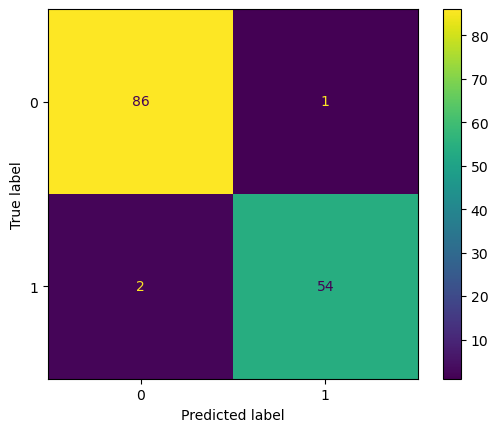

In [17]:
from sklearn.feature_selection import GenericUnivariateSelect
selector = GenericUnivariateSelect(f_classif, mode='fpr', param=0.0000001)
X_new = selector.fit_transform(X, y)
print(X_new.shape)

feature_scores = pd.DataFrame({'Features':df.columns[1:], 'Score': selector.pvalues_}).sort_values(by='Score', ascending=True)
display(feature_scores)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=2022)
model = LogisticRegression()
model.fit(X_train, y_train)
print(f"train score: {model.score(X_train, y_train)}")
print(f"test score: {model.score(X_test, y_test)}")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

##  随机森林（Random Forest）

随机森林是一种广泛使用的特征选择算法，它会自动计算各个特征的重要性，可以选择较小的特征子集。

随机森林是由很多决策树构成的，不同决策树之间没有关联。当进行分类任务时，新的输入样本进入，就让森林中的每一棵决策树分别进行判断和分类，每个决策树会得到一个自己的分类结果，决策树的分类结果中哪一个分类最多，那么随机森林就会把这个结果当做最终的结果。

,Features,importances
20,radius_worst,0.709493
27,concave points_worst,0.128715
21,texture_worst,0.072434
24,smoothness_worst,0.027818
13,area_se,0.020903
23,area_worst,0.012299
26,concavity_worst,0.010037
22,perimeter_worst,0.009608
17,concave points_se,0.008693
0,radius_mean,0.000000


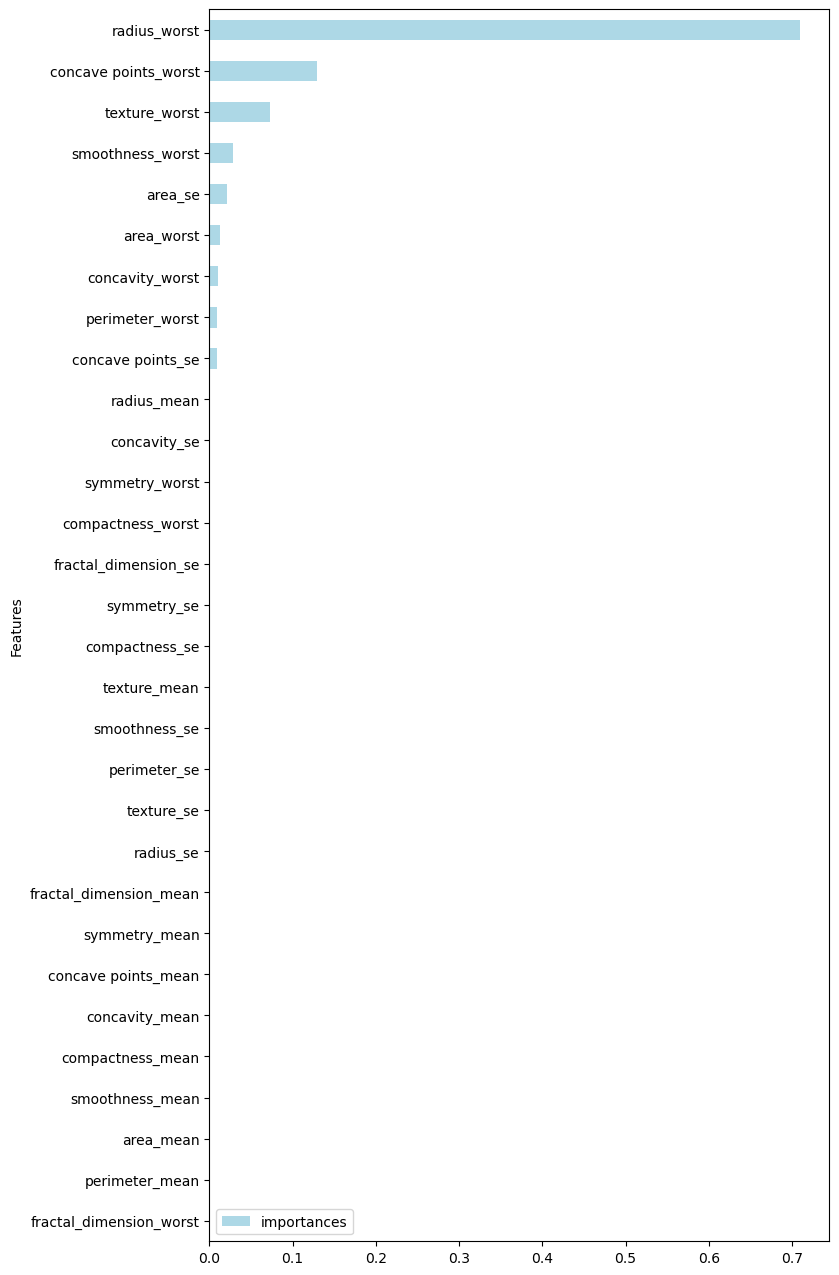

In [18]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2022)

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
feature_importances = pd.DataFrame({'Features':df.columns[1:], 'importances': dtc.feature_importances_}).sort_values(by='importances', ascending=False)
feature_importances.plot.barh(x='Features', y='importances', color='lightblue', figsize=(8, 16)).invert_yaxis()
display(feature_importances)

(569, 10)
train score: 0.9741784037558685
test score: 0.965034965034965


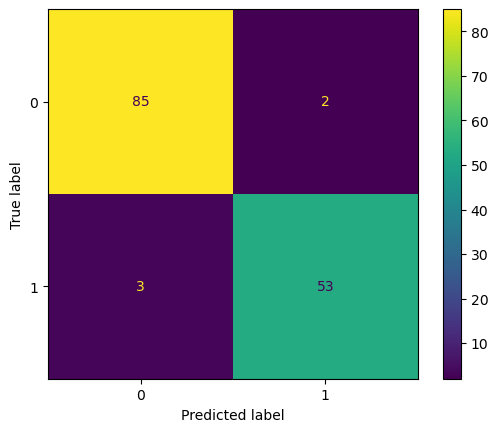

In [19]:
X_new = df[feature_importances["Features"][:10]]
print(X_new.shape)

X_new = StandardScaler().fit_transform(X_new)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=2022)

model = LogisticRegression()
model.fit(X_train, y_train)
print(f"train score: {model.score(X_train, y_train)}")
print(f"test score: {model.score(X_test, y_test)}")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

,Features,importances
27,concave points_worst,0.182592
22,perimeter_worst,0.137882
20,radius_worst,0.098564
23,area_worst,0.088423
7,concave points_mean,0.055442
0,radius_mean,0.053985
3,area_mean,0.051585
6,concavity_mean,0.046694
2,perimeter_mean,0.043529
13,area_se,0.039064


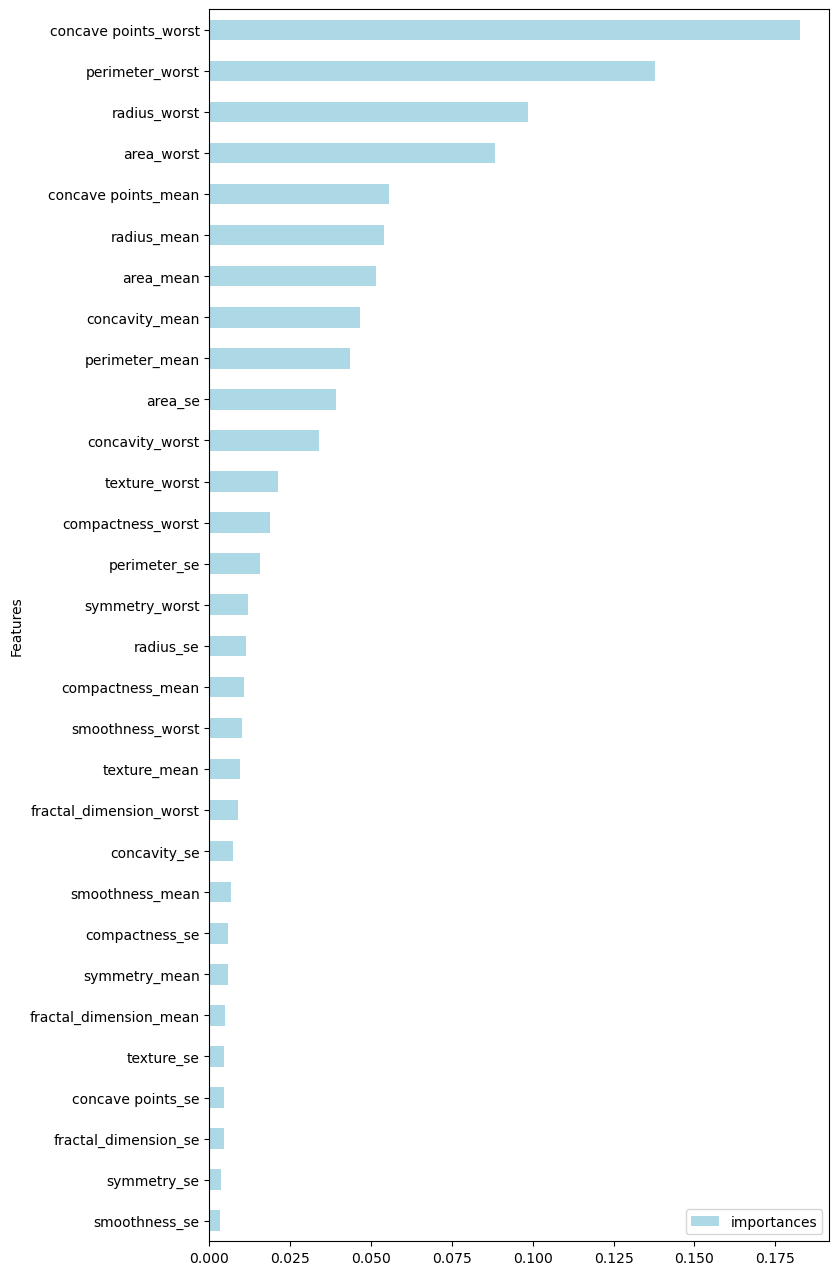

In [20]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2022)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
feature_importances = pd.DataFrame({'Features':df.columns[1:], 'importances': rfc.feature_importances_}).sort_values(by='importances', ascending=False)
feature_importances.plot.barh(x='Features', y='importances', color='lightblue', figsize=(8, 16)).invert_yaxis()
display(feature_importances)

(569, 10)
train score: 0.9507042253521126
test score: 0.965034965034965


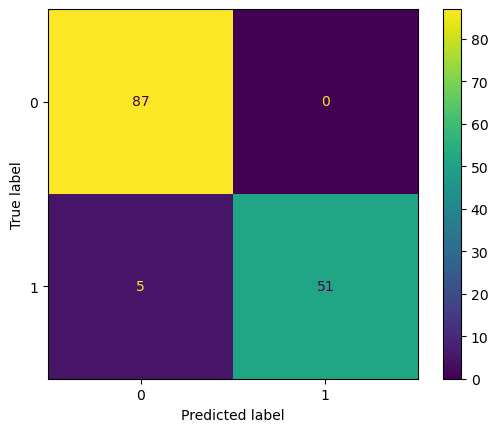

In [21]:
X_new = df[feature_importances["Features"][:10]]
print(X_new.shape)
X_new = StandardScaler().fit_transform(X_new)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=2022)

model = LogisticRegression()
model.fit(X_train, y_train)
print(f"train score: {model.score(X_train, y_train)}")
print(f"test score: {model.score(X_test, y_test)}")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

## 主成分分析(Principal Component Analysis, PCA)

`PCA` 是最常用的一种降维方法。`PCA` 由`Karl Pearson`在1901年发明，是一种线性降维方法。`PCA` 的目标是通过某种线性投影，将高维的数据映射到低维的空间中表示，并期望在所投影的维度上数据的方差最大，以此使用较少的数据维度，同时保留住较多的原数据点的特性，是将原空间变换到特征向量空间内。

`PCA` 的工作就是从原始的空间中顺序地找一组相互正交的坐标轴，新的坐标轴的选择与数据本身是密切相关的。其中，第一个新坐标轴选择是原始数据中方差最大的方向，第二个新坐标轴选取是与第一个坐标轴正交的平面中使得方差最大的，第三个轴是与第1，2个轴正交的平面中方差最大的。依次类推，可以得到 $n$ 个这样的坐标轴。通过这种方式获得的新的坐标轴，我们发现，大部分方差都包含在前面 $k$ 个坐标轴中，后面的坐标轴所含的方差几乎为0。于是，我们可以忽略余下的坐标轴，只保留前面 $k$ 个含有绝大部分方差的坐标轴。事实上，这相当于只保留包含绝大部分方差的维度特征，而忽略包含方差几乎为0的特征维度，实现对数据特征的降维处理。

`PCA` 降维要考虑的一个问题是，如果将样本点投影到一个超平面，使得：

- 最近重构性：样本点到超平面的距离尽可能近。

- 最大可分性：样本点在这个超平面上的投影尽可能分开。

<img src=https://www.biaodianfu.com/wp-content/uploads/2020/09/pca-1.png>

事实上，通过计算数据矩阵的协方差矩阵，然后得到协方差矩阵的特征值特征向量，选择特征值最大(即方差最大)的 $k$ 个特征所对应的特征向量组成的矩阵。这样就可以将数据矩阵转换到新的空间当中，实现数据特征的降维。

设有 $m$ 个 $n$ 维数据矩阵 $X$，设 $C=\frac{1}{m}XX^T$，则 $C$ 是一个对称矩阵，其对角线分别个各个特征的方差，而第 $i$ 行$j$ 列表示 $i$ 和 $j$ 两个字段的协方差(所有数据经过均值归零化之后)。

设 $Y = P^TX$ 表示投影后的数据，那么 $Y$ 的协方差矩阵
$$
D = \frac{1}{m}YY^T = \frac{1}{m} (P^TX)(P^TX)^T = P^T (\frac{1}{m} XX^T) P = P^T C P 
$$
所以，只需要寻找一个矩阵 $P$，满足$P^TCP$ 是一个对角矩阵，并且对角元素按从大到小依次排列，那么 $P$ 的前 $K$ 列就是要寻找的基，用 $P$ 的前 $K$ 列组成的矩阵的转置乘以 $X$ 就使得 $X$ 从 $n$ 维降到了 $k$ 维并满足上述优化条件。

由于得到协方差矩阵的特征值特征向量有两种方法：**特征值分解协方差矩阵**、**奇异值分解协方差矩阵**，所以`PCA`算法有两种实现方法：基于特征值分解协方差矩阵实现`PCA`算法、基于`SVD`分解协方差矩阵实现`PCA`算法。

`PCA` 的流程

1. 将原始数据按列组成 $n$ 行 $m$ 列矩阵 $X$。
   
2. 将 $X$ 的每一行进行零均值化，即减去这一行的均值。

3. 求出协方差矩阵 $C = \frac{1}{m} X X^T$。

4. 求出协方差矩阵的特征值及对应的特征向量。

5. 将特征向量按对应特征值大小从上到下按行排列成矩阵，取前 $k$ 行组成矩阵 $P$。
   
6. $Y = PX$ 即为降维到 $k$ 维后的数据。

作为一个非监督学习的降维方法，它只需要特征值分解，就可以对数据进行压缩，去噪。因此在实际场景应用很广泛。

PCA算法的主要优点有：

- 仅仅需要以方差衡量信息量，不受数据集以外的因素影响。　

- 各主成分之间正交，可消除原始数据成分间的相互影响的因素。

- 计算方法简单，主要运算是特征值分解，易于实现。

PCA算法的主要缺点有：

- 主成分各个特征维度的含义具有一定的模糊性，不如原始样本特征的解释性强。

- 方差小的非主成分也可能含有对样本差异的重要信息，因降维丢弃可能对后续数据处理有影响。

### Sklearn PCA
```python
sklearn.decomposition.PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto', random_state=None)
```

参数

- `n_components`：指定`PCA`降维后的特征维度数目。最常用的做法是直接指定降维到的维度数目，此时`n_components`是一个大于等于1的整数。当然，也可以指定主成分的方差和所占的最小比例阈值，让`PCA`类自己去根据样本特征方差来决定降维到的维度数，此时`n_components`是一个`（0，1]`之间的数。还可以将参数设置为`"mle"`, 此时`PCA`类会用`MLE`算法根据特征的方差分布情况自己去选择一定数量的主成分特征来降维。

- `whiten` ：判断是否进行白化。所谓白化，就是对降维后的数据的每个特征进行归一化，让方差都为1。对于`PCA`降维本身来说，一般不需要白化。如果`PCA`降维后有后续的数据处理动作，可以考虑白化。默认值是`False`，即不进行白化。

- `svd_solver`：即指定奇异值分解`SVD`的方法，由于特征分解是奇异值分解`SVD`的一个特例，一般的`PCA`库都是基于`SVD`实现的。有4个可以选择的值：`{'auto', 'full', 'arpack', 'randomized'}`。

  - `randomized`一般适用于数据量大，数据维度多同时主成分数目比例又较低的 `PCA` 降维，它使用了一些加快 `SVD` 的随机算法。
  
  - `full`则是传统意义上的`SVD`，使用了`scipy`库对应的实现。
  
  - `arpack`和`randomized`的适用场景类似，区别是`randomized`使用的是`scikit-learn`自己的`SVD`实现，而`arpack`直接使用了`scipy`库的`sparse SVD`实现。

  - 默认是`auto`，即`PCA`类会自己去在前面讲到的三种算法里面去权衡，选择一个合适的`SVD`算法来降维。一般来说，使用默认值就够了。

属性

- `components_`：返回具有最大方差的成分。
  
- `explained_variance_ratio_`：返回所保留的`n`个成分各自的方差百分比。
  
- `n_components_`：返回所保留的成分个数`n`。


方法

- `fit(X)` 用数据`X`来训练`PCA`模型。
  
- `fit_transform(X)` 用`X`来训练`PCA`模型，同时返回降维后的数据。
  
- `inverse_transform()` 将降维后的数据转换成原始数据。
  
- `transform(X)` 将数据`X`转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用`transform`方法来降维。

Text(0, 0.5, 'explained_variance_ratio_')

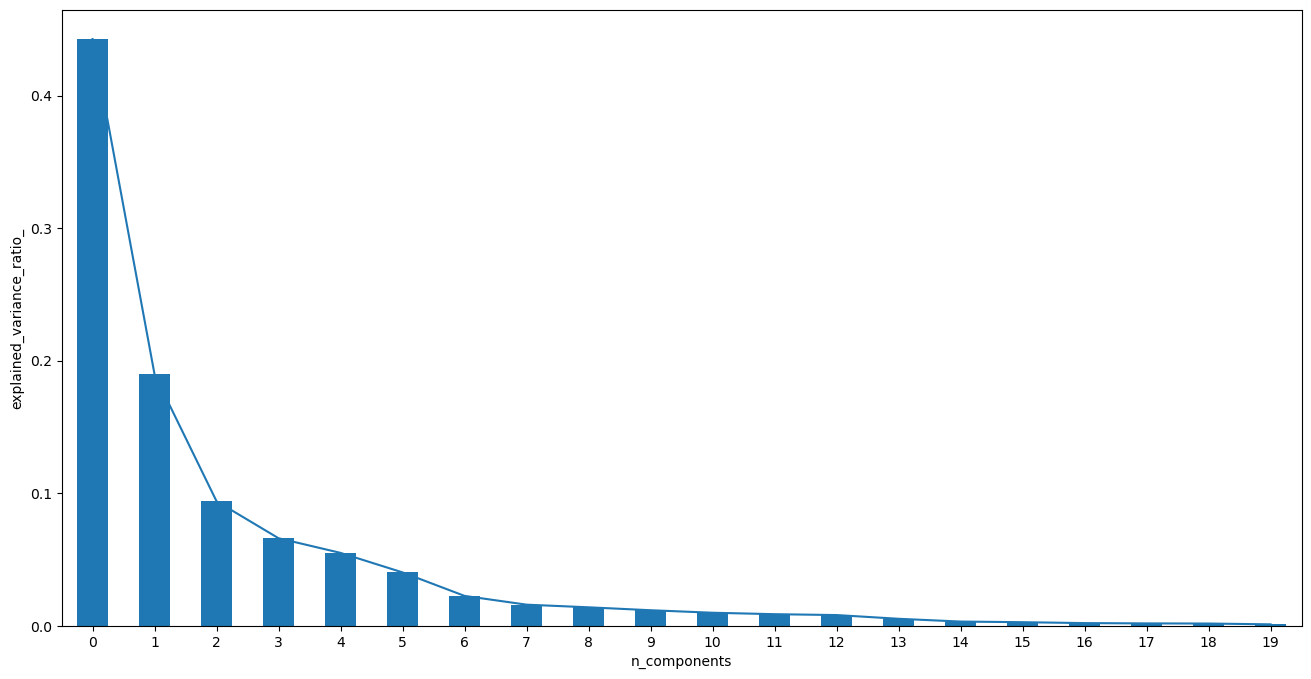

In [22]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

df_variance_ratio = pd.DataFrame(dict(data=pca.explained_variance_ratio_[:20]))

fig, ax = plt.subplots()

df_variance_ratio['data'].plot(kind='bar', figsize=(16,8))
df_variance_ratio['data'].plot(kind='line', ms=10)

plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

train score: 0.9859154929577465
test score: 0.9790209790209791


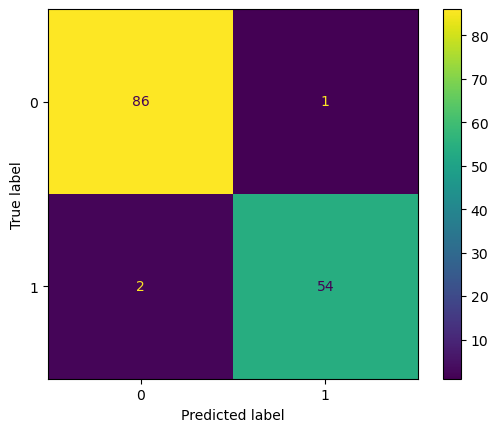

In [23]:
pca = PCA(n_components=10)
X_new = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=2022)

model = LogisticRegression()
model.fit(X_train, y_train)
print(f"train score: {model.score(X_train, y_train)}")
print(f"test score: {model.score(X_test, y_test)}")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

## t-SNE降维

`t-SNE`全称为 t-distributed Stochastic Neighbor Embedding，`t-SNE`的主要用途是可视化和探索高维数据。 它由Laurens van der Maatens和Geoffrey Hinton在JMLR第九卷(2008年)中开发并出版。 `t-SNE`的主要目标是将多维数据集转换为低维数据集。 相对于其他的降维算法，对于数据可视化而言`t-SNE`的效果最好。 如果我们将`t-SNE`应用于`n`维数据，它将智能地将`n`维数据映射到`3d`甚至`2d`数据，并且原始数据的相对相似性非常好。`t-SNE`不是线性降维技术，它遵循非线性，这是它可以捕获高维数据的复杂流形结构的主要原因。

c:\Users\mjye\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\mjye\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


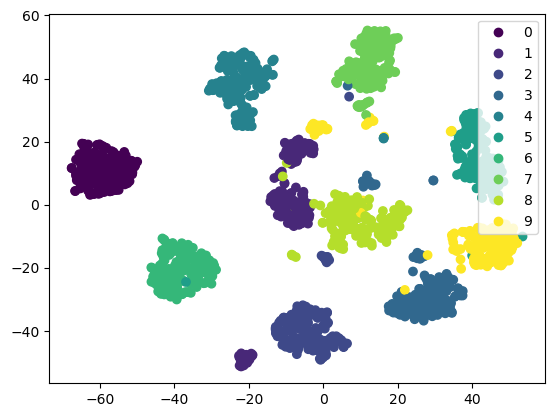

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import TSNE

digits = datasets.load_digits(n_class=10)
data = digits.data     
label = digits.target

tsne = TSNE(random_state=2022)

data_new = tsne.fit_transform(data)

scatter = plt.scatter(data_new[:,0], data_new[:,1], c=label)
plt.legend(*scatter.legend_elements(), loc='upper right')


c:\Users\mjye\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\mjye\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


train score: 0.9624413145539906
test score: 0.986013986013986


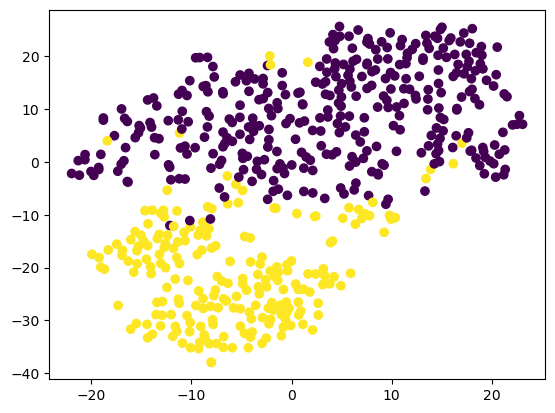

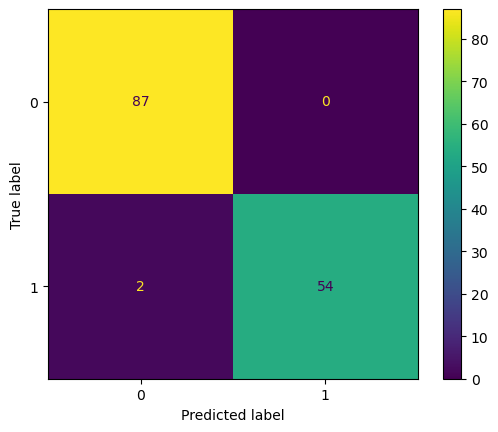

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=2022)
X_new = tsne.fit_transform(X)

plt.scatter(X_new[:,0], X_new[:,1], c=y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=2022)

model = LogisticRegression()
model.fit(X_train, y_train)
print(f"train score: {model.score(X_train, y_train)}")
print(f"test score: {model.score(X_test, y_test)}")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)